偏向スコアを用いた分析

In [1]:
# (2) ライブラリの読み込み
library("tidyverse")
library("haven")
library("broom")
library("MatchIt")
library("WeightIt")
library("cobalt")

# (3)NBER archiveからデータを読み込む
cps1_data <- read_dta("https://users.nber.org/~rdehejia/data/cps_controls.dta")
cps3_data <- read_dta("https://users.nber.org/~rdehejia/data/cps_controls3.dta")
nswdw_data <- read_dta("https://users.nber.org/~rdehejia/data/nsw_dw.dta")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter(

In [2]:
# データの確認
nswdw_data |> head() # これはRCTのデータ
cps1_data |> head()

data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Dehejia-Wahba Sample,1,37,11,1,0,1,1,0,0,9930.0459
Dehejia-Wahba Sample,1,22,9,0,1,0,1,0,0,3595.8940
Dehejia-Wahba Sample,1,30,12,1,0,0,0,0,0,24909.4492
Dehejia-Wahba Sample,1,27,11,1,0,0,1,0,0,7506.1460
Dehejia-Wahba Sample,1,33,8,1,0,0,1,0,0,289.7899
Dehejia-Wahba Sample,1,22,9,1,0,0,1,0,0,4056.4939


data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CPS1,0,45,11,0,0,1,1,21516.670,25243.551,25564.670
CPS1,0,21,14,0,0,0,0,3175.971,5852.565,13496.080
CPS1,0,38,12,0,0,1,0,23039.020,25130.760,25564.670
CPS1,0,48,6,0,0,1,1,24994.369,25243.551,25564.670
CPS1,0,18,8,0,0,1,1,1669.295,10727.610,9860.869
CPS1,0,22,11,0,0,1,1,16365.760,18449.270,25564.670


In [3]:
# (4)データセットの準備
## NSWデータから介入グループだけ取り出してCPS1と付ける
## バイアスのあるデータ
cps1_nsw_data <- nswdw_data |>
  filter(treat == 1) |>
  rbind(cps1_data) # 行を結合する

## NSWデータから介入グループだけ取り出してCPS3と付ける
## バイアスのあるデータ
cps3_nsw_data <- nswdw_data |>
  filter(treat == 1) |>
  rbind(cps3_data)

In [4]:
# (5) RCT データでの分析
## 共変量なしの回帰分析
nsw_nocov <- lm(data = nswdw_data,
                formula = re78 ~ treat) %>%
  tidy()

nsw_nocov 
#真の効果量は1794.342らしいということがわかる。 
#介入なしでは4554.801、介入ありで4554.801+1794.342

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4554.801,408.0459,11.162474,1.154114e-25
treat,1794.342,632.8534,2.835321,4.787530e-03


In [5]:
## 共変量付きの回帰分析
nsw_cov <- lm(data = nswdw_data,
              formula = re78 ~ treat + re74 + re75 + age + education + black +
                hispanic + nodegree + married
              ) %>%
  tidy() %>%
  filter(term == "treat")
nsw_cov #回帰分析では効果量は1676.343と推定。真の効果量と近くはある。

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
treat,1676.343,638.682,2.624691,0.0089781


In [6]:
# (6) バイアスのあるデータでの回帰分析
## CPS1の分析結果
cps1_reg <- lm(data = cps1_nsw_data, #これがバイアスのあるデータ
               formula = re78 ~ treat + re74 + re75 + age + education + black +
                 hispanic + nodegree + married
               ) %>%
  tidy() %>%
  filter(term == "treat")
cps1_reg #めちゃくちゃ効果量が小さく出ている
# なぜならば介入群は失業者に限定しているのに対して非介入群は失業者に限定していないので、非介入群の所得が高く出やすい

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
treat,699.1317,547.6361,1.276636,0.2017493


In [7]:
## CPS3の分析結果
cps3_reg <- lm(data = cps3_nsw_data,
               formula = re78 ~ treat + re74 + re75 + age + education + black +
                 hispanic + nodegree + married
               ) %>%
  tidy() %>%
  filter(term == "treat")
cps3_reg # 効果量が真の場合と近くなった
# なぜならば非介入群を失業者に限定してデータを取り直したから

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
treat,1548.244,781.2793,1.981678,0.04796825


傾向スコアを用いてやってみる

Warning message:
“Standardized mean differences and raw mean differences are present in the same plot. 
Use the 'stars' argument to distinguish between them and appropriately label the x-axis.”


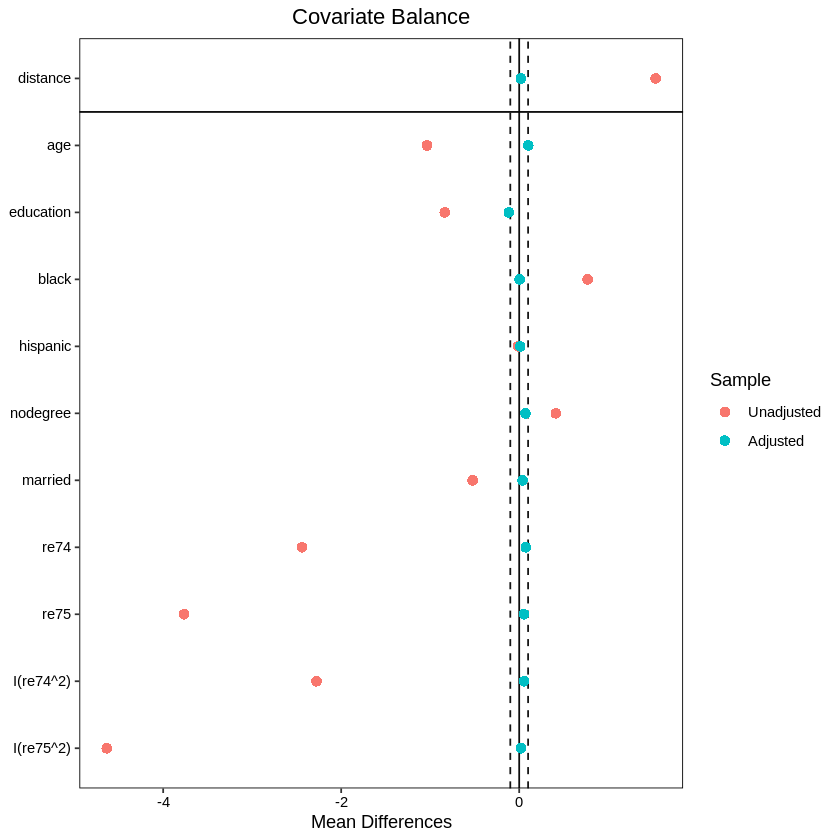

In [8]:
# (7) 傾向スコアマッチングによる効果推定
## 傾向スコアを用いたマッチング
m_near <- matchit(formula = treat ~ age + education + black + hispanic +
                    nodegree + married + re74 + re75 + I(re74^2) + I(re75^2),
                  data = cps1_nsw_data,
                  method = "nearest")

## 共変量のバランスを確認
love.plot(m_near,
          threshold = .1)

## 上手くバランスが取れるようになっている！

In [9]:
## マッチング後のデータを作成
matched_data <- match.data(m_near)

## マッチング後のデータで効果の推定
PSM_result_cps1 <- lm(data = matched_data,
                      formula = re78 ~ treat) %>%
  tidy()

PSM_result_cps1 #効果は1877と真の効果に近くなっている！

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4471.952,506.1323,8.835541,4.151846e-17
treat,1877.191,715.7791,2.622585,9.089132e-03


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“Some extreme weights were generated. Examine them with summary() and maybe trim them with trim().”
Warning message:
“Standardized mean differences and raw mean differences are present in the same plot. 
Use the 'stars' argument to distinguish between them and appropriately label the x-axis.”


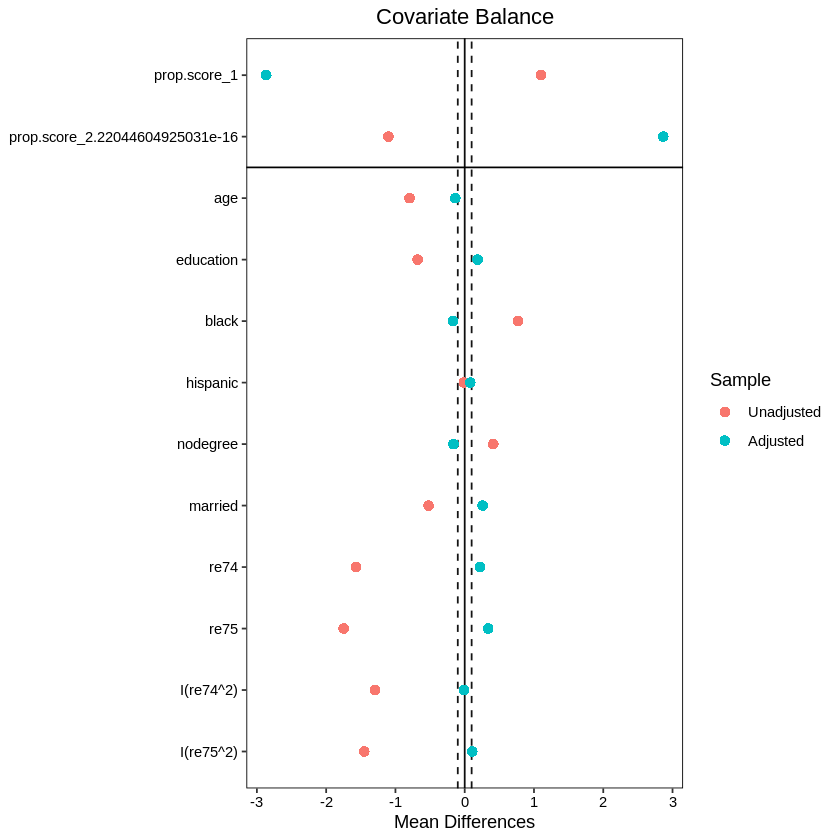

In [10]:
# (8) IPWによる効果推定
## 重みの推定
weighting <- weightit(formula = treat ~ age + education + black + hispanic +
                        nodegree + married + re74 + re75 +
                        I(re74^2) + I(re75^2),
                      data = cps1_nsw_data,
                      method = "ps",
                      estimand = "ATE")

## 共変量のバランスを確認
love.plot(weighting,
          threshold = .1)

# バランスはイマイチ

In [11]:
## 重み付きデータでの効果の推定
IPW_result <- lm(data = cps1_nsw_data,
                 formula = re78 ~ treat,
                 weights = weighting$weights) %>%
  tidy()

IPW_result #教科書とめちゃくちゃ結果が違う。そして真の効果量とも結果が違う
# これは上記と異なり、介入と非介入の分布全体の効果量を見ている

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3269.521,87.2602,37.46864,1.009501e-294
treat,3581.017,111.9524,31.98695,9.471377e-218


IPWは、介入グループと非介入グループの傾向の違いが大きい場合に信頼しにくい。傾向スコアが0か1に近い値を取ると、逆比の重み付けが極端な値になってしまい不安定だから。

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“Some extreme weights were generated. Examine them with summary() and maybe trim them with trim().”
Warning message:
“Standardized mean differences and raw mean differences are present in the same plot. 
Use the 'stars' argument to distinguish between them and appropriately label the x-axis.”


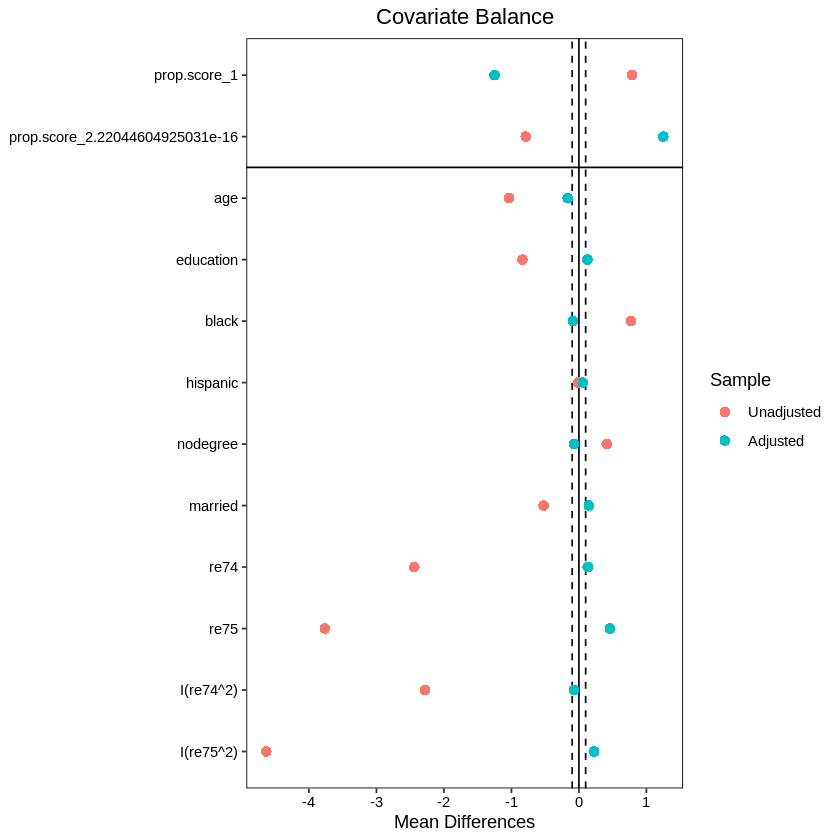

In [12]:
# (9) IPWによる効果推定(ATT)
## 重みの推定
weighting <- weightit(formula = treat ~ age + education + black + hispanic + nodegree + married + re74 + re75 + I(re74^2) + I(re75^2),
                      data = cps1_nsw_data,
                      method = "ps",
                      estimand = "ATT")

## 共変量のバランスを確認
love.plot(weighting,
          threshold = .1)

In [13]:
## 重み付きデータでの効果の推定
IPW_result <- lm(data = cps1_nsw_data,
                 formula = re78 ~ treat,
                 weights = weighting$weights) %>%
  tidy()
IPW_result

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3269.521,4.179065e+01,7.823569e+01,0.0000000
treat,3079.623,1.761711e+09,1.748086e-06,0.9999986
